# MovieLens 1M Dataset Exploration

This notebook explores the MovieLens 1M dataset that will be used in our user modeling strategies comparison experiments.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root directory to path for imports
sys.path.append('..')
from src.utils.data_loader import load_movielens_1m, preprocess_data, stratify_users

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline


In [2]:
# Path to dataset
DATA_DIR = "../data/raw/ml-1m"

# Path to image output directory
IMG_DIR = "../images/data"

# Create IMG_DIR if it doesn't exist
os.makedirs(IMG_DIR, exist_ok=True)

# Load data
users_data, ratings_data, movies_data = load_movielens_1m(DATA_DIR)

print(f"Users: {len(users_data)}")
print(f"Ratings: {len(ratings_data)}")
print(f"Movies: {len(movies_data)}")

Users: 6040
Ratings: 1000209
Movies: 3883


## Exploring Users Data

In [3]:
# Display first few rows
users_data.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Gender distribution:
gender
M    4331
F    1709
Name: count, dtype: int64


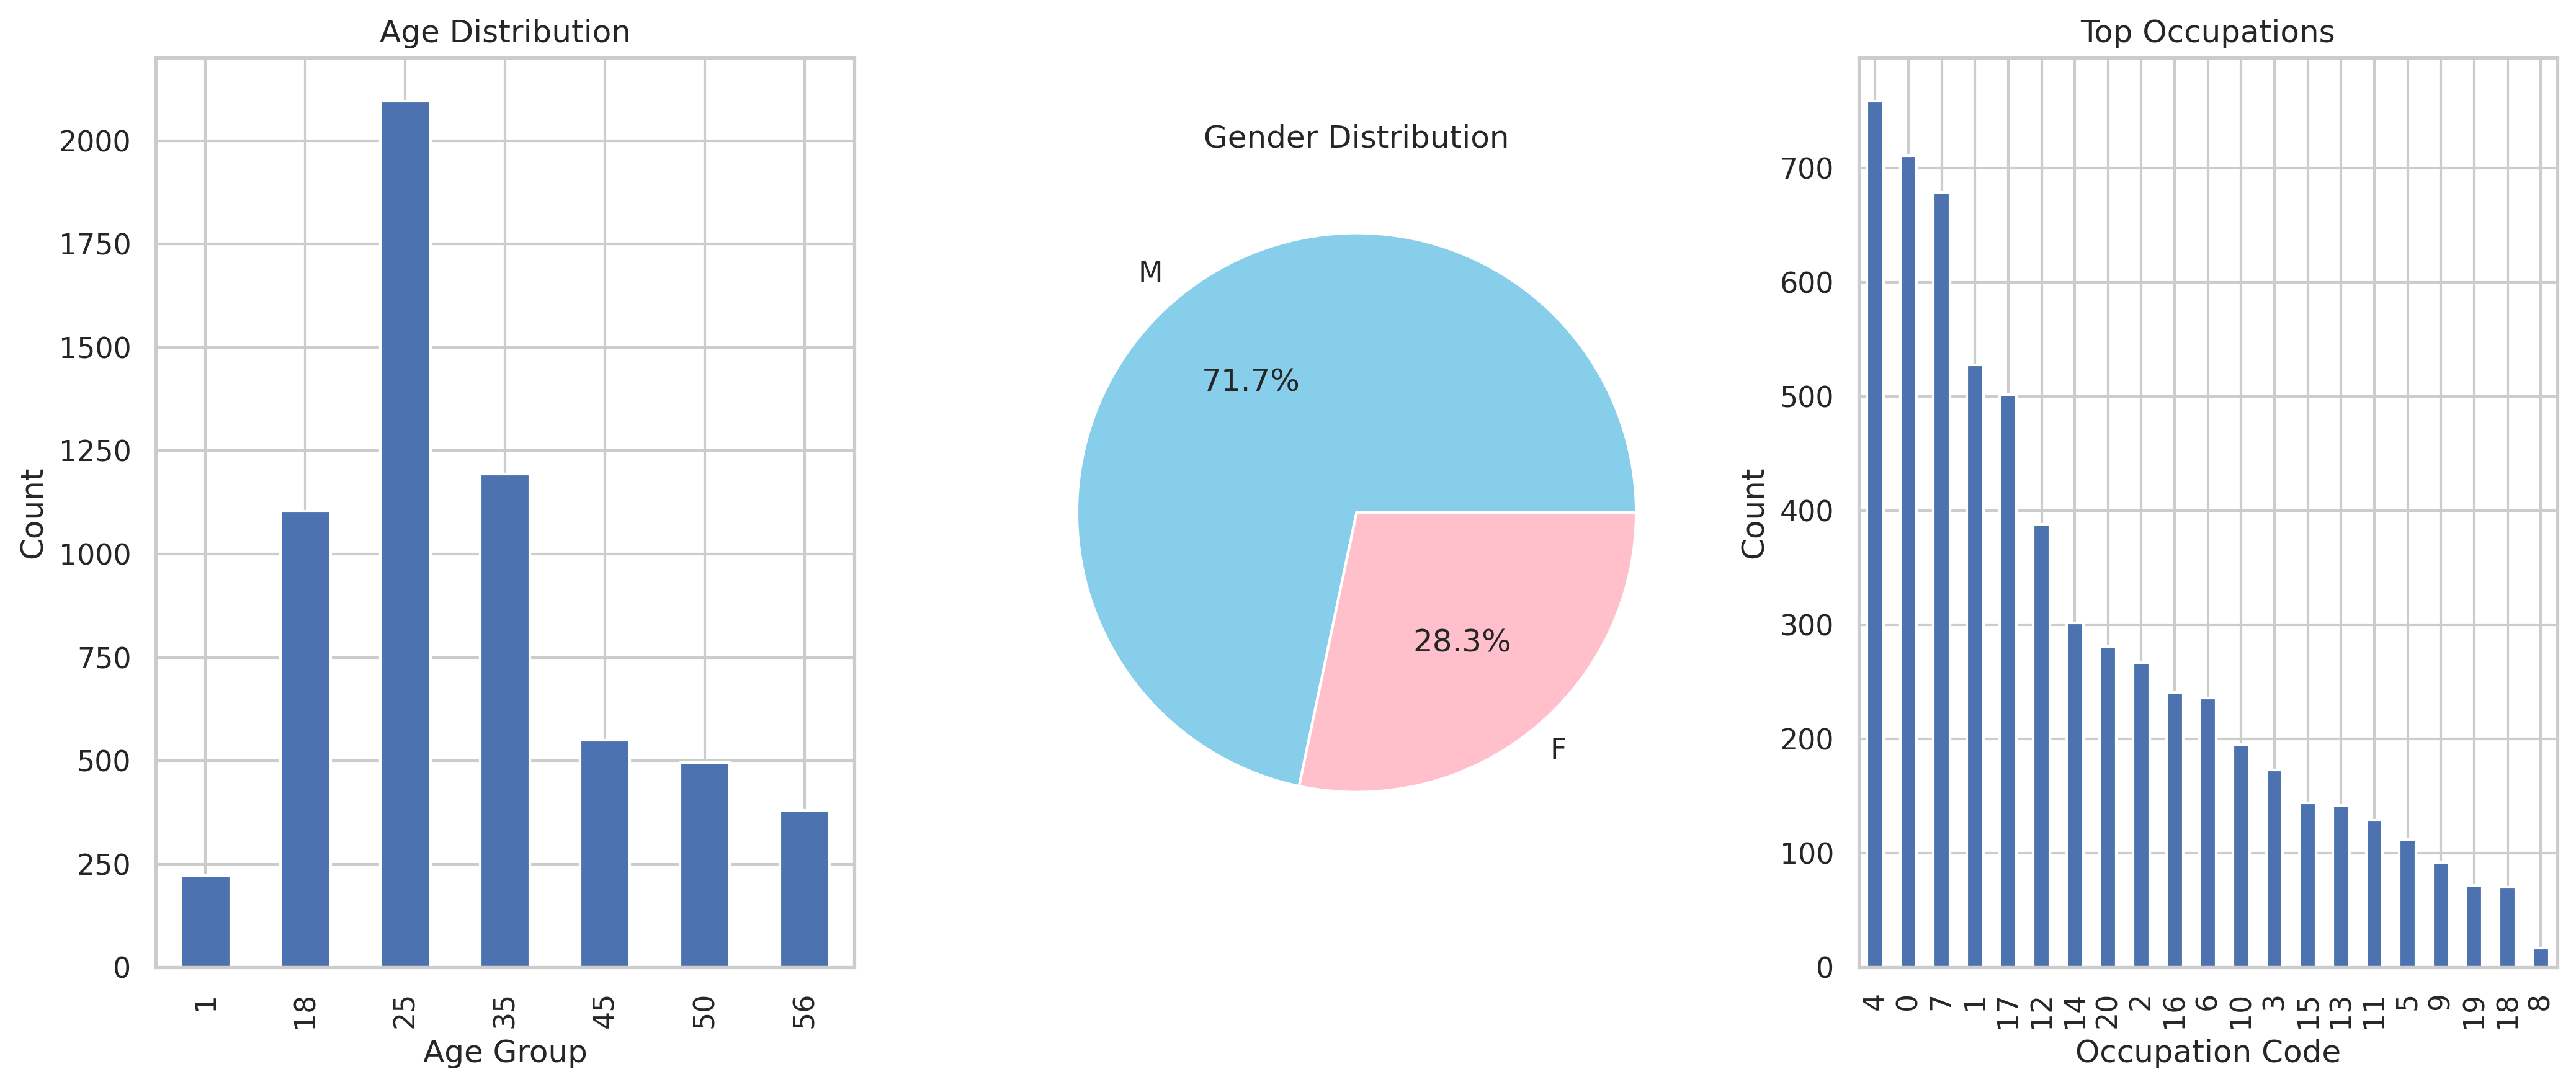

In [4]:
# Demographic statistics
print("Gender distribution:")
print(users_data['gender'].value_counts())

plt.figure(figsize=(14, 6), dpi=300)

# Age distribution
plt.subplot(131)
users_data['age'].value_counts().sort_index().plot(kind='bar')
plt.title('Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Gender distribution
plt.subplot(132)
users_data['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'pink'])
plt.title('Gender Distribution')
plt.ylabel('')

# Occupation distribution
plt.subplot(133)
users_data['occupation'].value_counts().plot(kind='bar')
plt.title('Top Occupations')
plt.xlabel('Occupation Code')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()

# Save figure with high DPI
plt.savefig(os.path.join(IMG_DIR, 'demographic_stats.png'), dpi=300, bbox_inches='tight')
plt.show()

## Exploring Ratings Data

In [5]:
# Display first few rows
ratings_data.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


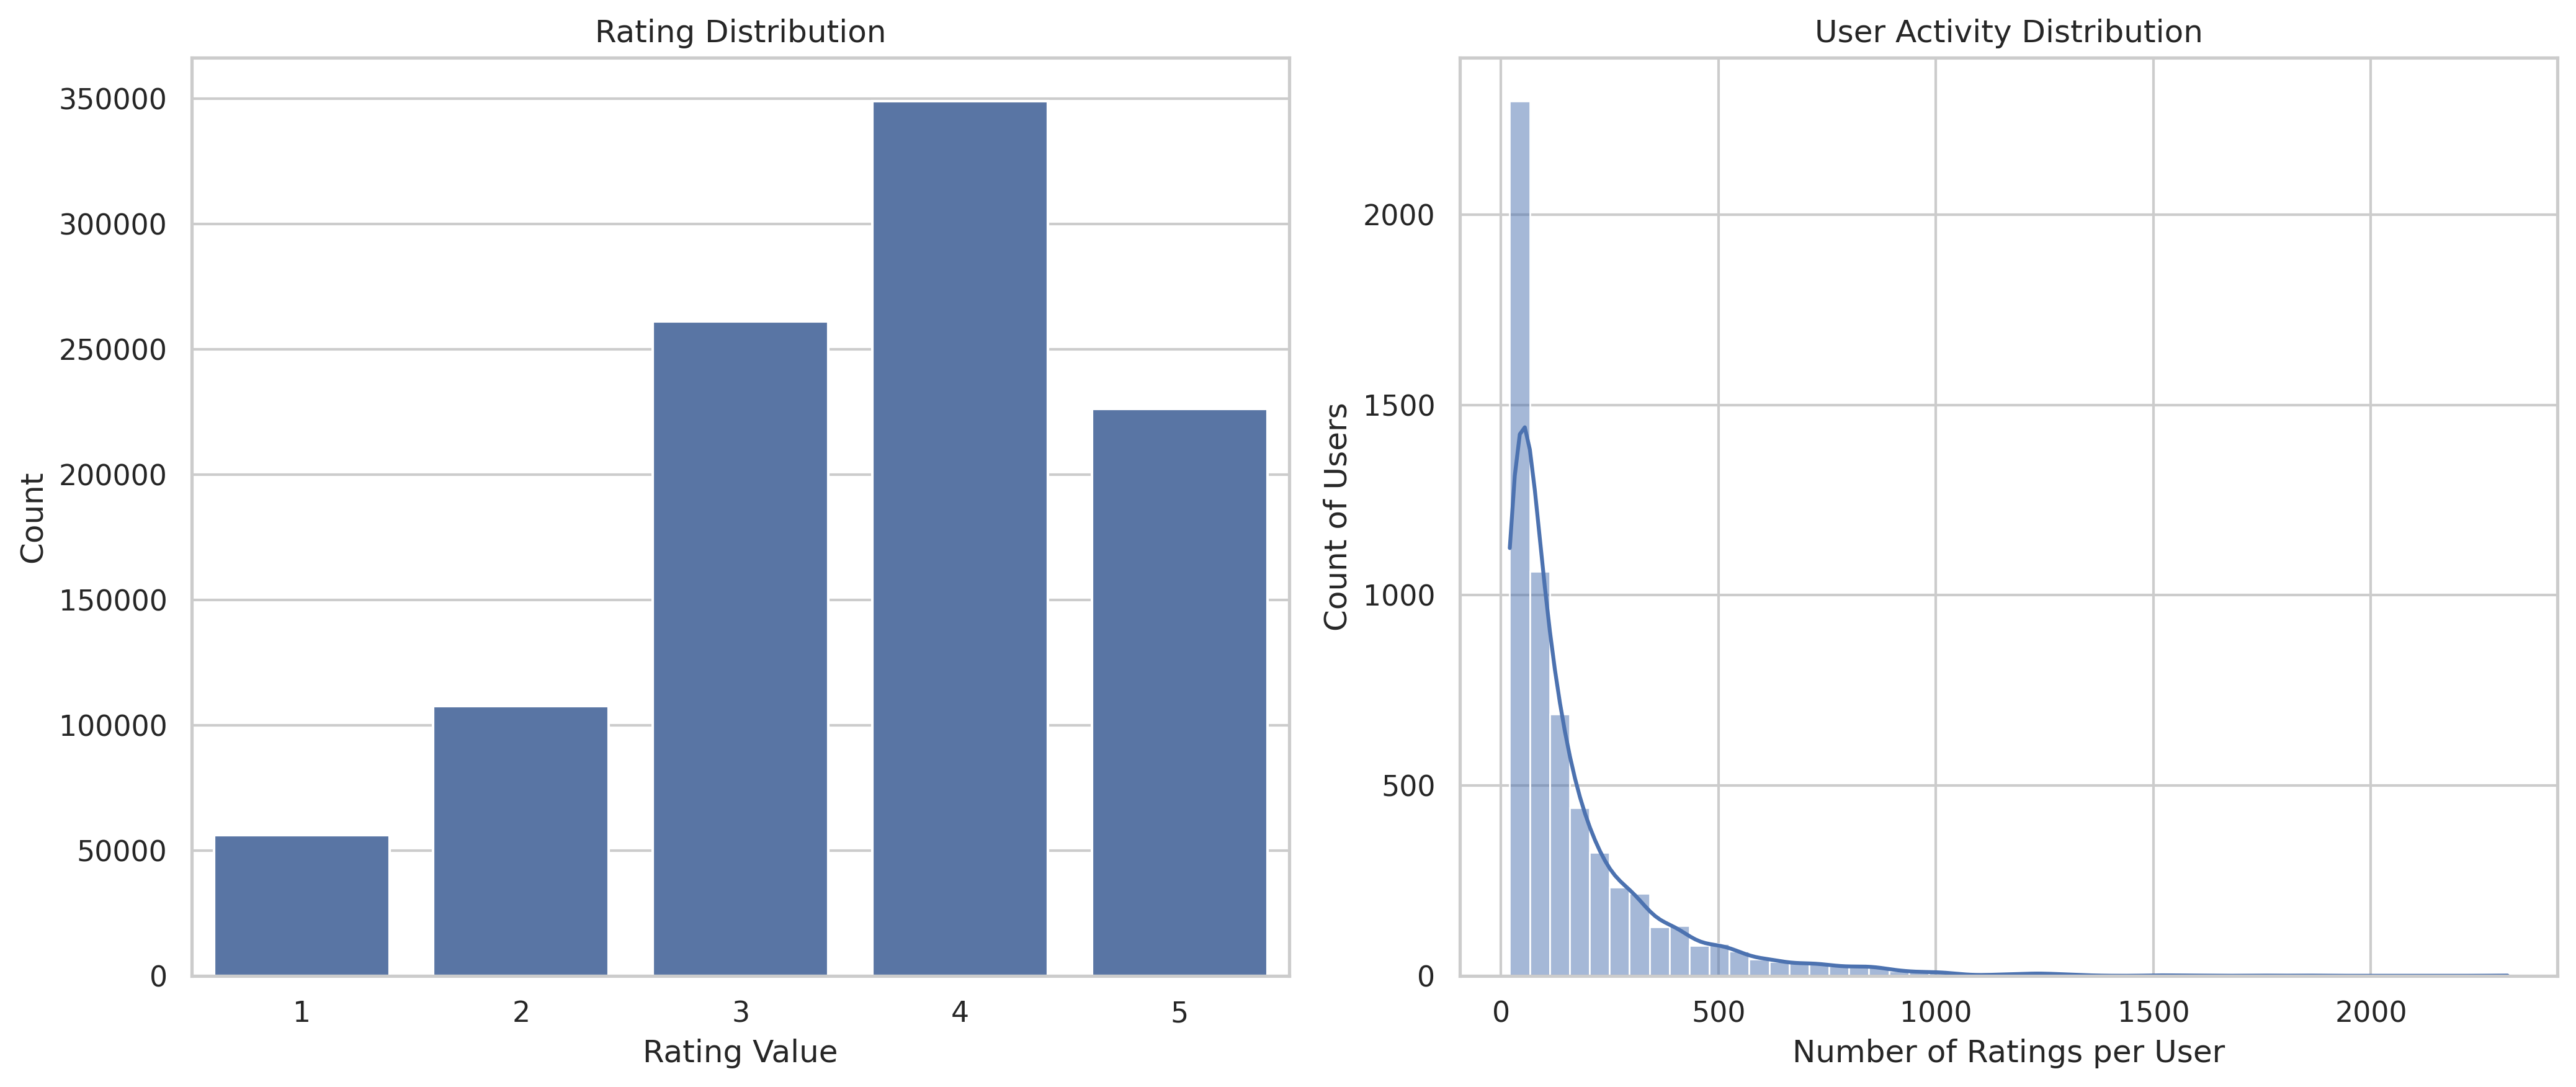

In [6]:
# Rating statistics
plt.figure(figsize=(14, 6), dpi=300)

# Rating distribution
plt.subplot(121)
sns.countplot(x='rating', data=ratings_data)
plt.title('Rating Distribution')
plt.xlabel('Rating Value')
plt.ylabel('Count')

# User activity distribution
plt.subplot(122)
user_counts = ratings_data['user_id'].value_counts()
sns.histplot(user_counts, bins=50, kde=True)
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Count of Users')

plt.tight_layout()

# Save figure with high DPI
plt.savefig(os.path.join(IMG_DIR, 'rating_stats.png'), dpi=300, bbox_inches='tight')
plt.show()

## User Stratification by Interaction Density

In [7]:
# Preprocess data (filter low-activity users)
users_data_processed, ratings_data_processed = preprocess_data(users_data, ratings_data, min_interactions=5)

print(f"Users after preprocessing: {len(users_data_processed)}")
print(f"Ratings after preprocessing: {len(ratings_data_processed)}")

Users after preprocessing: 6040
Ratings after preprocessing: 1000209


In [8]:
# Stratify users
user_strata = stratify_users(ratings_data_processed)

print(f"Sparse users: {len(user_strata['sparse'])}")
print(f"Medium users: {len(user_strata['medium'])}")
print(f"Dense users: {len(user_strata['dense'])}")

Sparse users: 2004
Medium users: 2015
Dense users: 2021


In [9]:
# Analyze rating counts in each stratum
user_counts = ratings_data_processed['user_id'].value_counts().reset_index()
user_counts.columns = ['user_id', 'rating_count']

# Add stratum info
user_counts['stratum'] = 'unknown'
user_counts.loc[user_counts['user_id'].isin(user_strata['sparse']), 'stratum'] = 'sparse'
user_counts.loc[user_counts['user_id'].isin(user_strata['medium']), 'stratum'] = 'medium'
user_counts.loc[user_counts['user_id'].isin(user_strata['dense']), 'stratum'] = 'dense'

# Analyze rating counts by stratum
stratum_stats = user_counts.groupby('stratum')['rating_count'].agg(['min', 'max', 'mean', 'median', 'count'])
stratum_stats

,min,max,mean,median,count
stratum,,,,,
dense,156,2314,362.507175,291.0,2021
medium,57,155,97.814888,95.0,2015
sparse,20,56,35.172156,34.0,2004


/tmp/ipykernel_50871/677622144.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stratum', y='rating_count', data=user_counts, palette=colors)


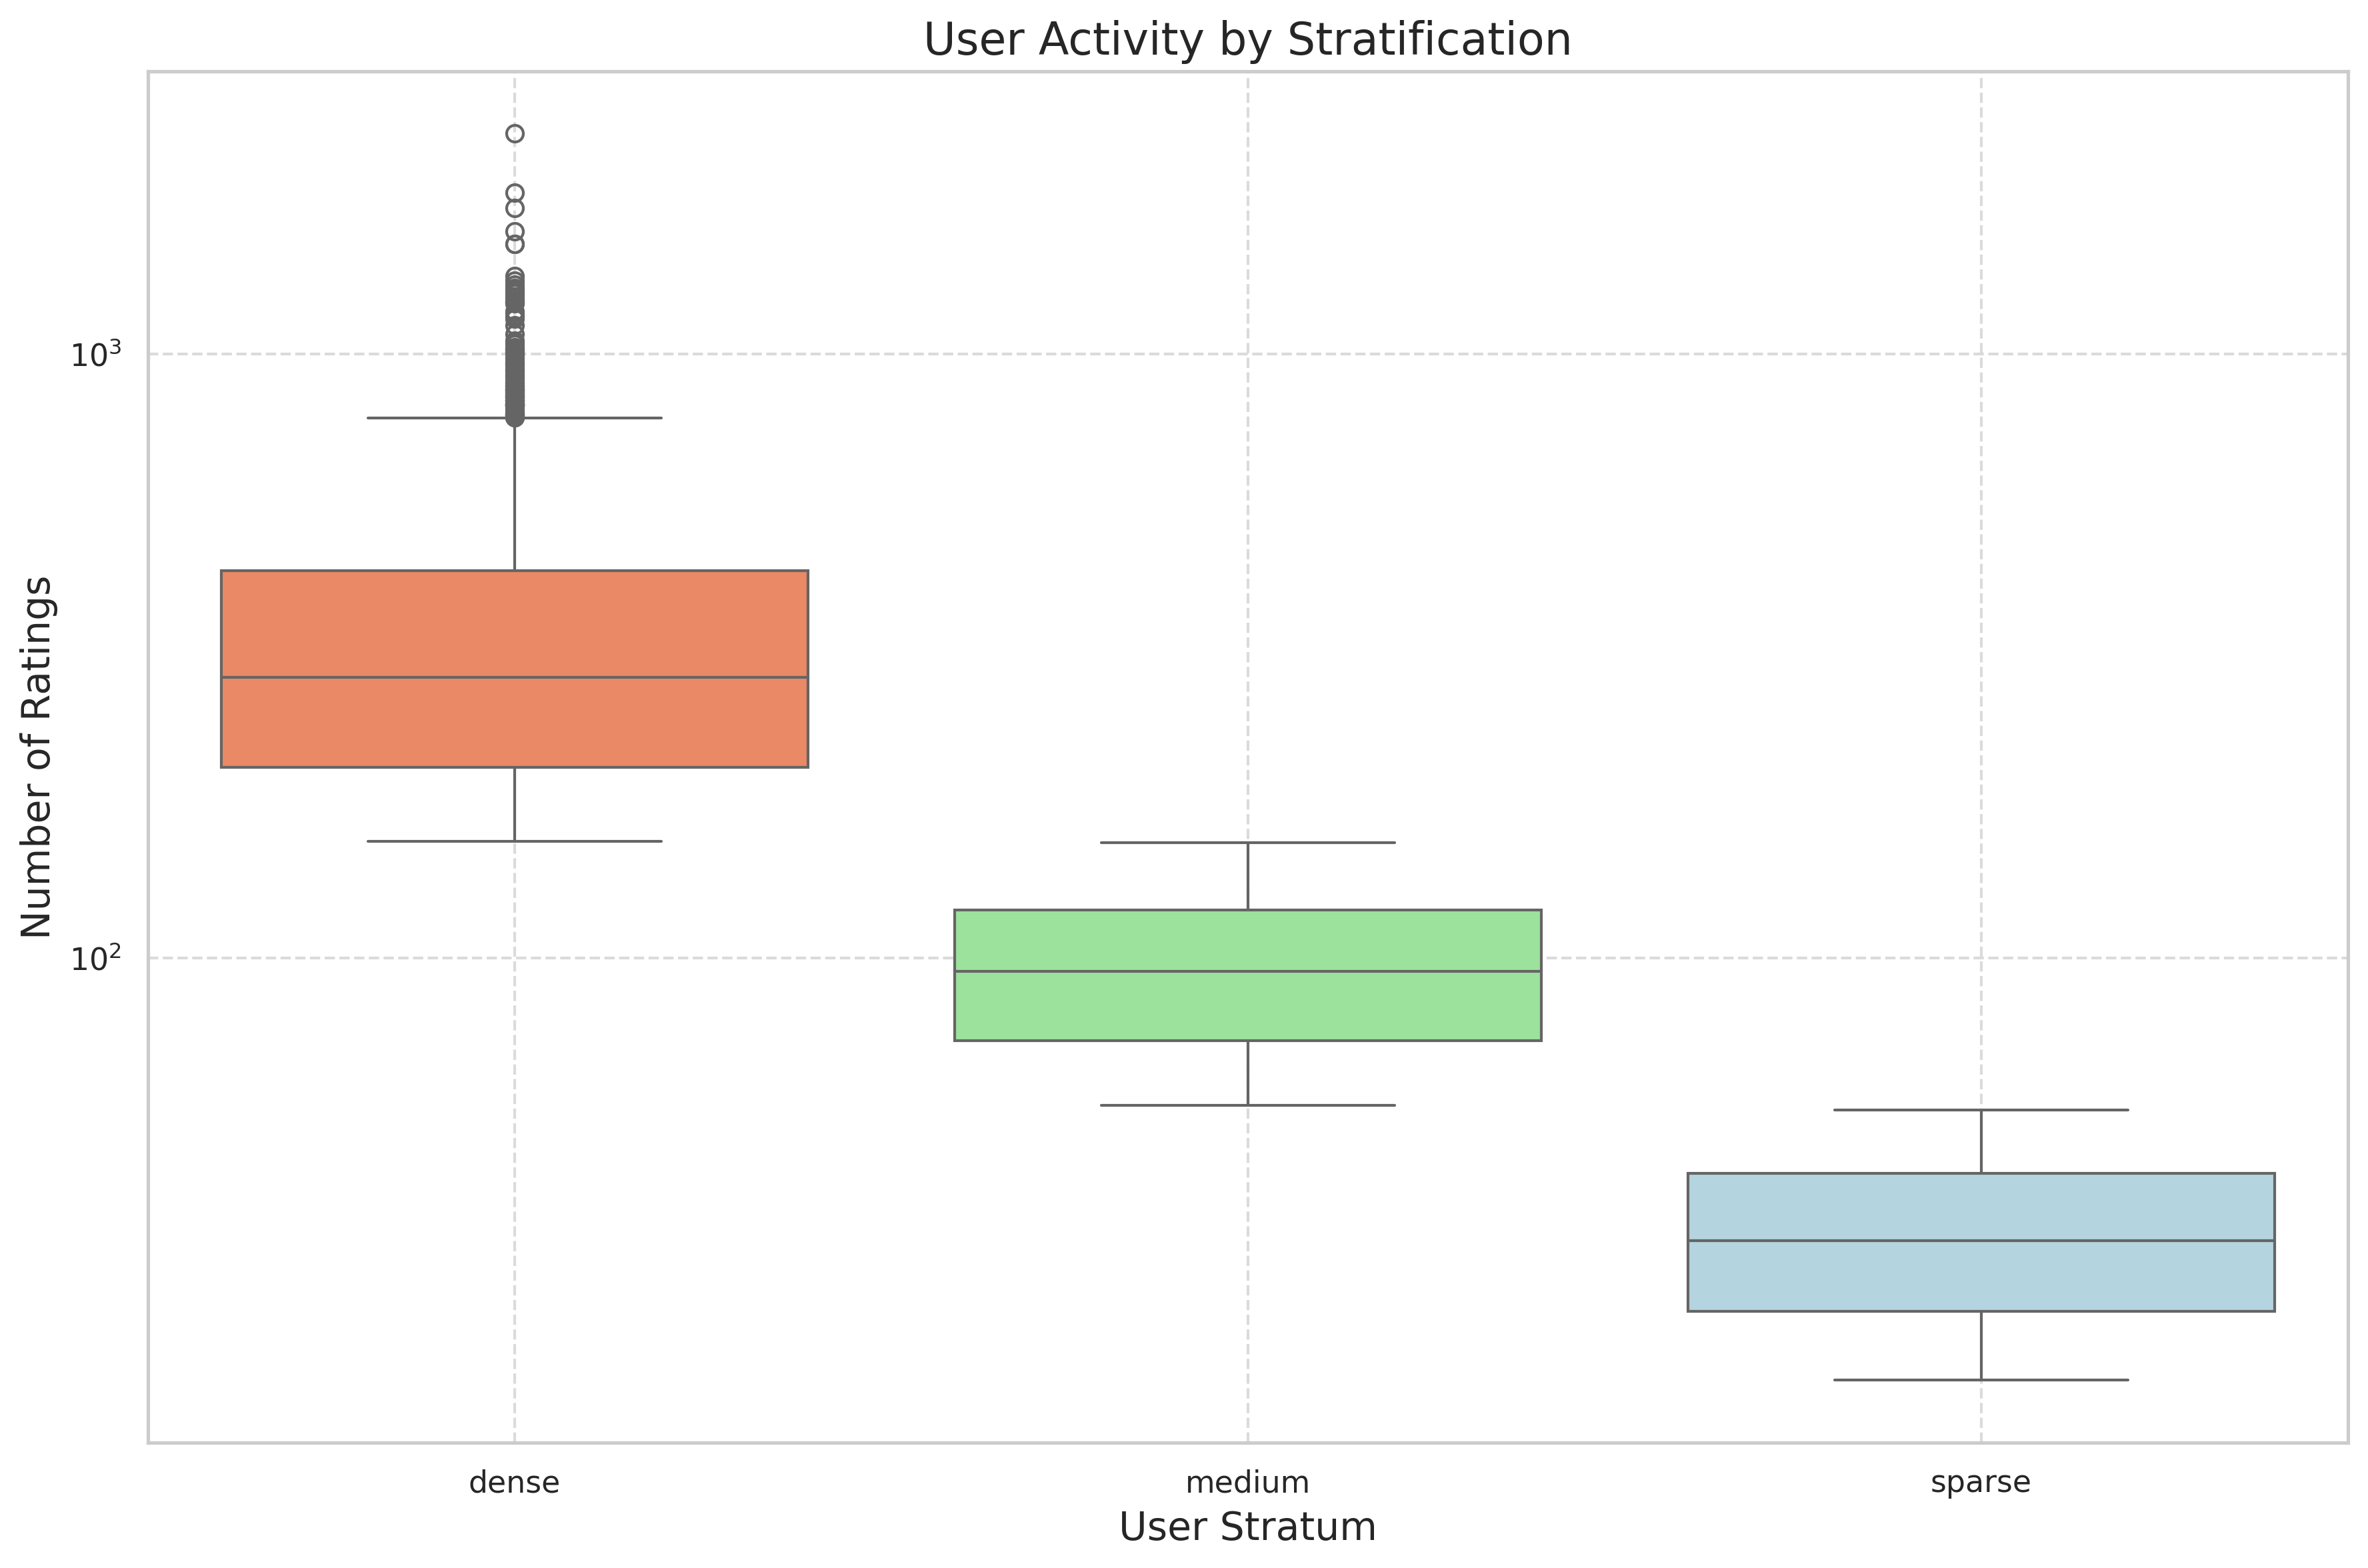

In [10]:
# Visualize the strata
plt.figure(figsize=(12, 8), dpi=300)

colors = {'sparse': 'lightblue', 'medium': 'lightgreen', 'dense': 'coral'}
sns.boxplot(x='stratum', y='rating_count', data=user_counts, palette=colors)

plt.title('User Activity by Stratification', fontsize=16)
plt.xlabel('User Stratum', fontsize=14)
plt.ylabel('Number of Ratings', fontsize=14)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure with high DPI
plt.savefig(os.path.join(IMG_DIR, 'rating_by_user_stratum.png'), dpi=300, bbox_inches='tight')
plt.show()

## Demographic Profile by Stratum

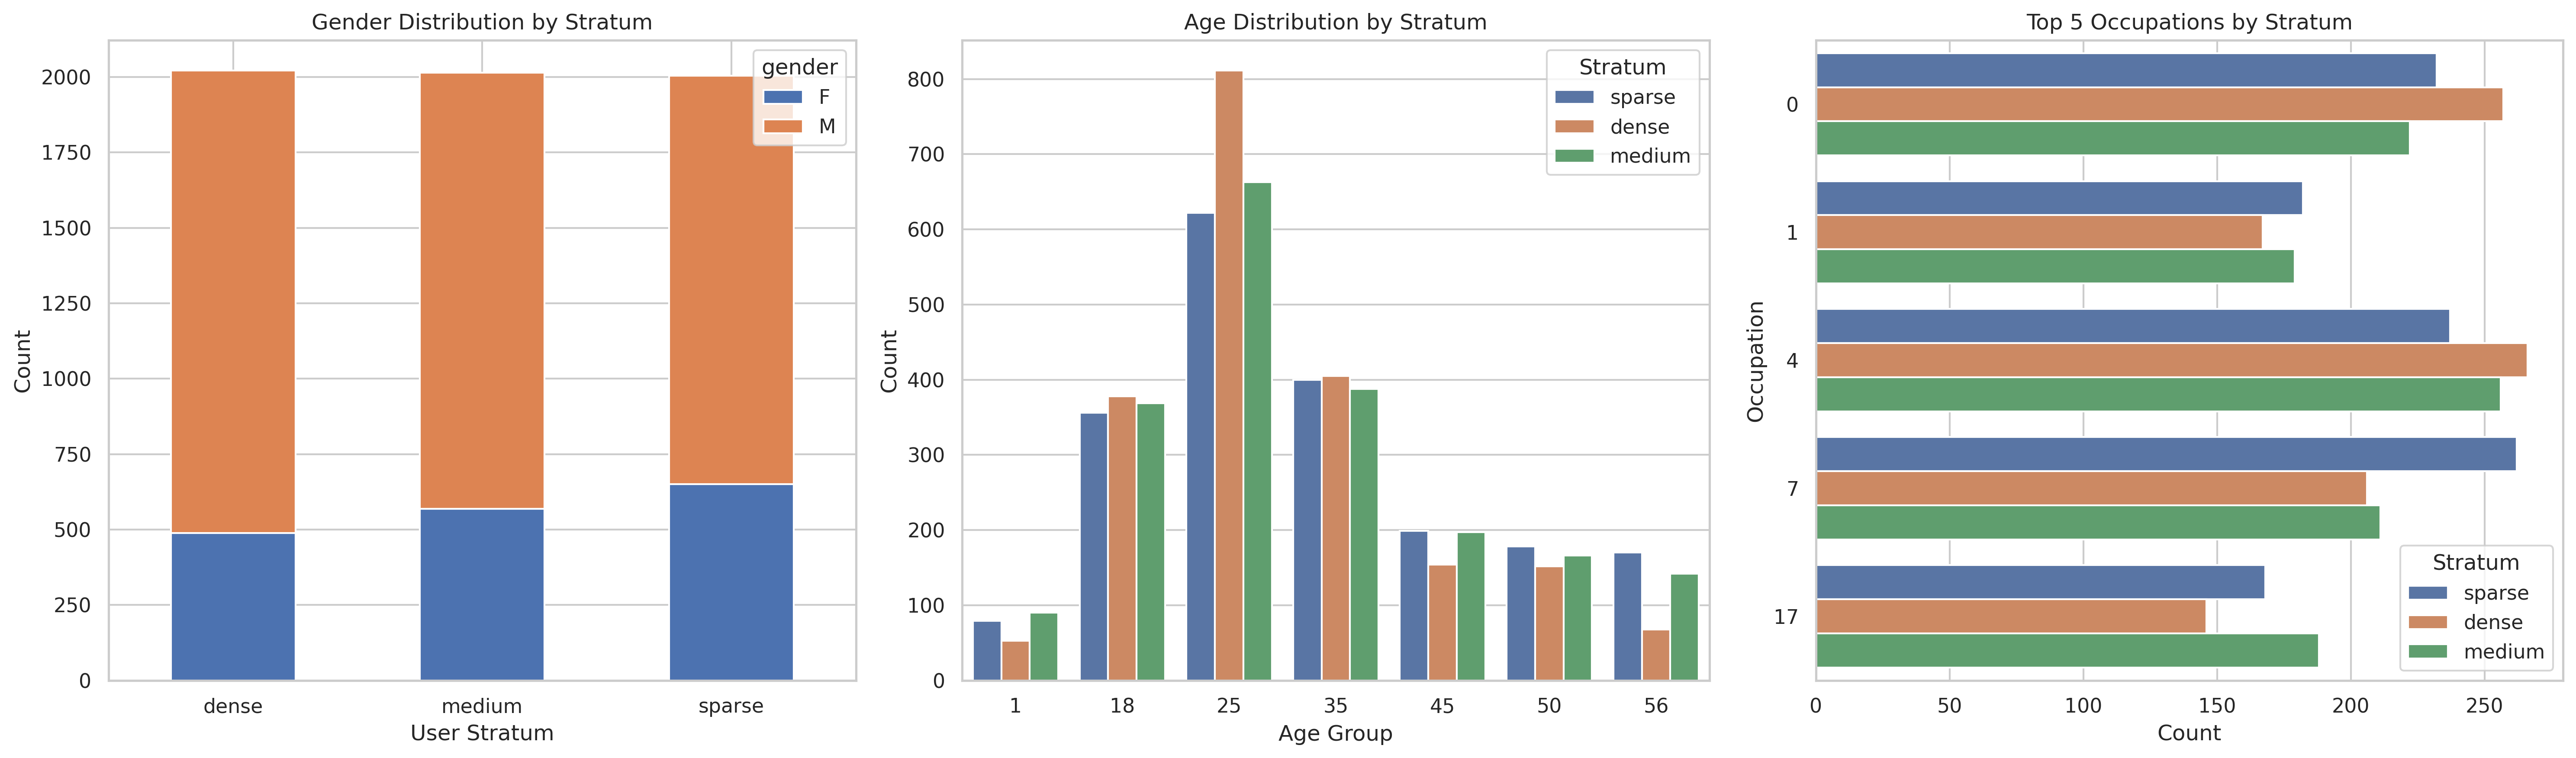

In [11]:
# Add stratum information to users_data
users_with_strata = users_data_processed.copy()
users_with_strata['stratum'] = 'unknown'
users_with_strata.loc[users_with_strata['user_id'].isin(user_strata['sparse']), 'stratum'] = 'sparse'
users_with_strata.loc[users_with_strata['user_id'].isin(user_strata['medium']), 'stratum'] = 'medium'
users_with_strata.loc[users_with_strata['user_id'].isin(user_strata['dense']), 'stratum'] = 'dense'

# Create figure and axes for the subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=300)

# --- Plot 1: Gender distribution by stratum ---
gender_by_stratum = users_with_strata.groupby(['stratum', 'gender']).size().unstack()
gender_by_stratum.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Gender Distribution by Stratum')
axes[0].set_xlabel('User Stratum')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# --- Plot 2: Age distribution by stratum ---
sns.countplot(x='age', hue='stratum', data=users_with_strata, ax=axes[1])
axes[1].set_title('Age Distribution by Stratum')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].legend(title='Stratum')

# --- Plot 3: Occupation distribution by stratum (top 5) ---
top_occupations = users_with_strata['occupation'].value_counts().nlargest(5).index
occupation_data = users_with_strata[users_with_strata['occupation'].isin(top_occupations)]
sns.countplot(y='occupation', hue='stratum', data=occupation_data, ax=axes[2])
axes[2].set_title('Top 5 Occupations by Stratum')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Occupation')
axes[2].legend(title='Stratum')

# Adjust layout and display the plot
plt.tight_layout()

# Save figure with high DPI
plt.savefig(os.path.join(IMG_DIR, 'demographic_by_user_stratum.png'), dpi=300, bbox_inches='tight')
plt.show()